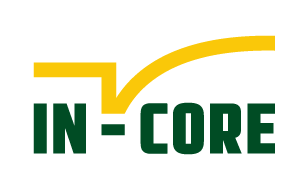


# Roadway Damage

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
pandas version:  1.4.2
numpy version:  1.22.3


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'/Users/mr77/Desktop/ProjectFiles/HybridResiliencePaper/Jupyter Notebooks/01_Damage_Transportation_Roadways'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

Enter username: rmehrzad90
Enter password: ········
Connection successful to IN-CORE services. pyIncore version detected: 1.4.1


## 2) Setting up an alternative plotting function to plot spatially

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    gdf = gdf.to_crs(epsg=3857)

    if category == False: # adding a colorbar to side
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                      cax=cax,
                     **kwargs)

    elif category == True:
        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                     **kwargs)

        
    if basemap:
        ctx.add_basemap(ax, source=source)

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## 3) Hazard Model (Hurricane)

In [24]:
hazard_type = "hurricane"

There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

### What is the your desired hurricane simulation?

In [53]:
hur_hazard_dict = {1: "5fa5a228b6429615aeea4410", 
                   2: "5fa5a83c7e5cdf51ebf1adae",
                   3: "5fa5a9497e5cdf51ebf1add2",
                   4: "5fa5aa19b6429615aeea4476",
                   5: "5f15cd627db08c2ccc4e3bab"}
hur_no = int(input('The No. of your desired hurricane simulation: '))

The No. of your desired hurricane simulation: 4


In [54]:
hazard_id=hur_hazard_dict[hur_no]
hazard_id

'5fa5aa19b6429615aeea4476'

In [55]:
path_to_output = os.path.join(os.getcwd(), 'output', 'Results for Hurricane No{}' .format(hur_no))
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

# 3) Roadways inventory, fragility, and damage

## INVENTORY

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed road inventory
Number of road segments: 163


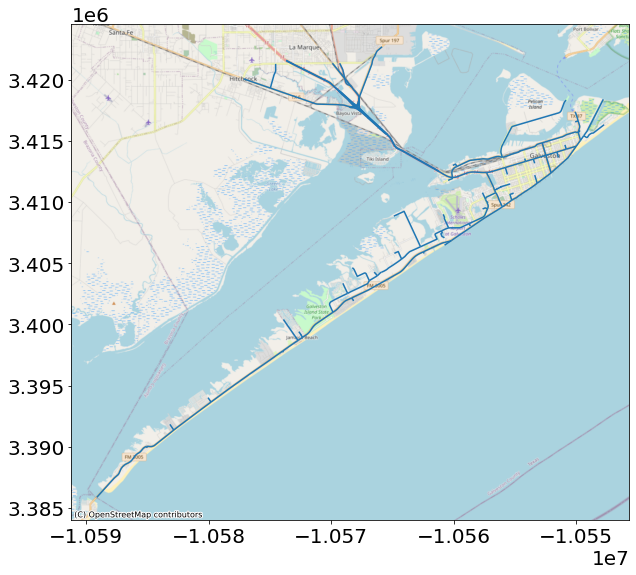

In [56]:
trns_road_dataset_id = "60ba6340aed73f24c5c5eaca"        # defining transportation bridge dataset (GIS point layer)
trns_road_dataset = Dataset.from_data_service(trns_road_dataset_id, data_service)

geoviz.plot_map(trns_road_dataset, column=None, category=False, basemap=True)
print('Galveston testbed road inventory')

trns_road_df = trns_road_dataset.get_dataframe_from_shapefile()
print('Number of road segments: {}' .format(len(trns_road_df)))

## FRAGILITY

In [57]:
# use utility method of pyicore-viz package to visualize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("60ba57b71f2b7d4a916fae88"))
fragility_set

# no preview: distance is one of the dimensions of fragility curve, which comes from the inventory.

## DAMAGE

In [58]:
result_name = os.path.join(path_to_output, 'Galveston_trns_road_dmg_result_hurNo{}' .format(hur_no))
result_name

'/Users/mr77/Desktop/ProjectFiles/HybridResiliencePaper/Jupyter Notebooks/01_Damage_Transportation_Roadways/output/Results for Hurricane No4/Galveston_trns_road_dmg_result_hurNo4'

In [59]:
mapping_id = "60ba583b1f2b7d4a916faf03"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

trns_road_dmg = RoadDamage(client)
trns_road_dmg.load_remote_input_dataset("roads", trns_road_dataset_id)
trns_road_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

trns_road_dmg.set_parameter("fragility_key", "Non-Retrofit inundationDepth Fragility ID Code")
trns_road_dmg.set_parameter("result_name", result_name)
trns_road_dmg.set_parameter("hazard_type", hazard_type)
trns_road_dmg.set_parameter("hazard_id", hazard_id)
trns_road_dmg.set_parameter("num_cpu", 4)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [60]:
trns_road_dmg.run_analysis()
print('Damage analysis is done for', np.size(trns_road_df,0) ,'roads')

Damage analysis is done for 163 roads


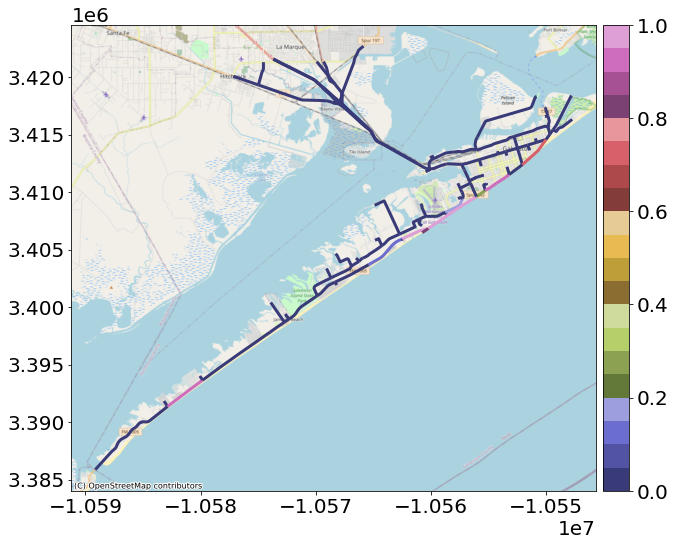

In [61]:
for filepath in glob.iglob(result_name+ '*.csv'):
    Galveston_trns_road_dmg_result_df = pd.read_csv(filepath)
trns_road_df = trns_road_df.to_crs(epsg=3857)

# merging the two above
trns_road_df_forplot = pd.merge(trns_road_df, Galveston_trns_road_dmg_result_df ['DS_4'], left_index=True, right_index=True)
plot_gdf_map(trns_road_df_forplot, column='DS_4', vmin=0, vmax=1, cmap='tab20b', linewidth=3, markersize = 1)